# Google Play App Market Structure & Revenue Drivers Analysis

## Problem Statement
Analyze Google Play app market structure and revenue drivers using clustering and regression.

## Objectives
- Perform Data Cleaning & EDA
- Implement K-Means Clustering (Market Segmentation)
- Implement Demand Estimation using Regression (Paid Apps Only)
- Build Revenue Prediction Logic
- Provide Business Interpretation


In [ ]:
!pip install kagglehub seaborn scikit-learn

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Step 1: Load Dataset

In [ ]:
# Download dataset
path = kagglehub.dataset_download('gauthamp10/google-playstore-apps')
print('Dataset Path:', path)

df_original = pd.read_csv(os.path.join(path, 'Google-Playstore.csv'))
print('Original Shape:', df_original.shape)
df_original.head()

100%|██████████| 207M/207M [00:02<00:00, 73.7MB/s]

Extracting files...


Dataset Path: /root/.cache/kagglehub/datasets/gauthamp10/google-playstore-apps/versions/7
Original Shape: (2312944, 24)


,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,...,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,...,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,...,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,...,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,...,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


## Step 2: Data Cleaning

In [ ]:
# Create working copy
df = df_original.copy()

# Remove duplicate apps
df = df.drop_duplicates(subset=['App Name'])

# ── Fix Installs: stored as '1,000+' or '10,000+' strings ──
df['Installs'] = (
    df['Installs']
    .astype(str)
    .str.replace(',', '', regex=False)   # remove commas
    .str.replace('+', '', regex=False)   # remove plus signs
    .str.replace('Free', '0', regex=False)
    .str.strip()
)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# ── Fix Price: may have '$' prefix ──
df['Price'] = (
    df['Price']
    .astype(str)
    .str.replace('$', '', regex=False)
    .str.strip()
)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# ── Fix Rating ──
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Drop rows where Installs is still missing
df = df[df['Installs'].notna()]

# Fill remaining missing values
df['Rating'] = df['Rating'].fillna(0)
df['Price']  = df['Price'].fillna(0)

print('Cleaned Shape:', df.shape)
print('Installs sample values:', df['Installs'].head().tolist())
df[['App Name', 'Rating', 'Price', 'Installs']].head()

Cleaned Shape: (2177837, 24)
Installs sample values: [10.0, 5000.0, 50.0, 10.0, 100.0]


,App Name,Rating,Price,Installs
0,Gakondo,0.0,0.0,10.0
1,Ampere Battery Info,4.4,0.0,5000.0
2,Vibook,0.0,0.0,50.0
3,Smart City Trichy Public Service Vehicles 17UC...,5.0,0.0,10.0
4,GROW.me,0.0,0.0,100.0


In [ ]:
# Log-transform installs to reduce skewness
df['Log_Installs'] = np.log1p(df['Installs'])

print('Sample stats:')
df[['Rating', 'Price', 'Installs', 'Log_Installs']].describe()

Sample stats:


,Rating,Price,Installs,Log_Installs
count,2.177837e+06,2.177837e+06,2.177837e+06,2.177837e+06
mean,2.172037e+00,1.062821e-01,1.780851e+05,6.138051e+00
std,2.106878e+00,2.604683e+00,1.544299e+07,3.131168e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,5.000000e+01,3.931826e+00
50%,2.800000e+00,0.000000e+00,5.000000e+02,6.216606e+00
75%,4.300000e+00,0.000000e+00,5.000000e+03,8.517393e+00
max,5.000000e+00,4.000000e+02,1.000000e+10,2.302585e+01


## Step 3: Exploratory Data Analysis (EDA)


### Cell 1 — Rating Distribution:

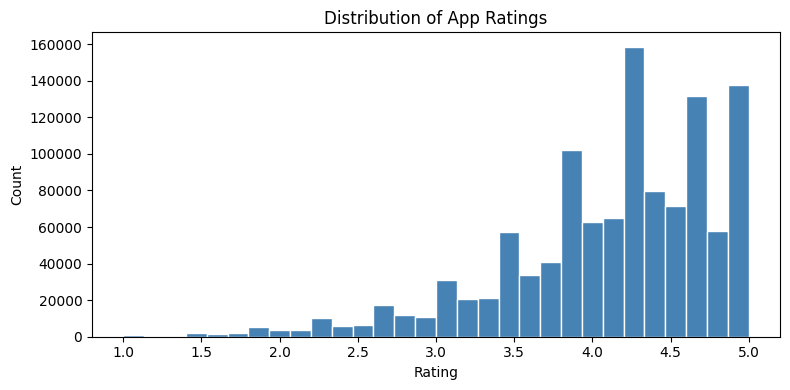

Average Rating : 4.10
Median Rating  : 4.20


In [ ]:

plt.figure(figsize=(8, 4))
plt.hist(df['Rating'][df['Rating'] > 0], bins=30, color='steelblue', edgecolor='white')
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(f"Average Rating : {df[df['Rating'] > 0]['Rating'].mean():.2f}")
print(f"Median Rating  : {df[df['Rating'] > 0]['Rating'].median():.2f}")

### Cell 2 — Installs Distribution:

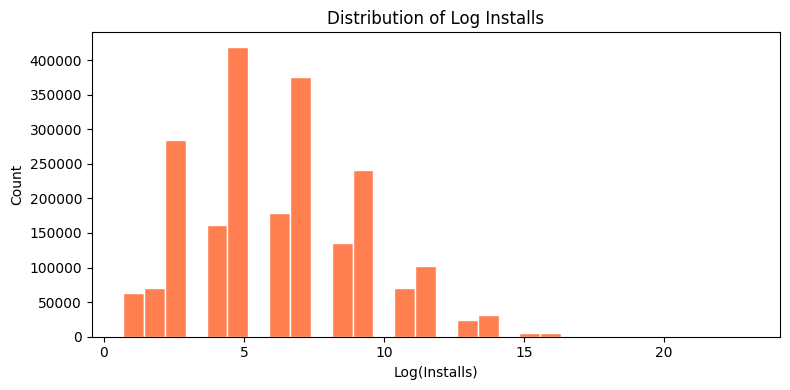

Median Installs : 500
Max Installs    : 10,000,000,000


In [ ]:
# EDA 2: Log Installs Distribution
plt.figure(figsize=(8, 4))
plt.hist(df['Log_Installs'][df['Log_Installs'] > 0], bins=30, color='coral', edgecolor='white')
plt.title('Distribution of Log Installs')
plt.xlabel('Log(Installs)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(f"Median Installs : {df['Installs'].median():,.0f}")
print(f"Max Installs    : {df['Installs'].max():,.0f}")

### Cell 3 — Free vs Paid Apps:

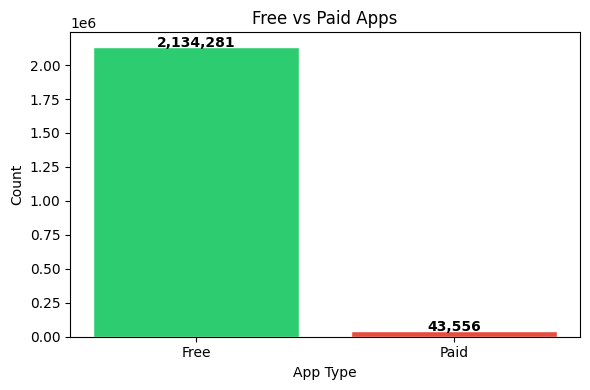

Free Apps : 2,134,281
Paid Apps : 43,556


In [ ]:
# EDA 3: Free vs Paid Apps
app_type = df['Price'].apply(lambda x: 'Paid' if x > 0 else 'Free').value_counts()

plt.figure(figsize=(6, 4))
bars = plt.bar(app_type.index, app_type.values, color=['#2ecc71', '#e74c3c'], edgecolor='white')
plt.title('Free vs Paid Apps')
plt.xlabel('App Type')
plt.ylabel('Count')
for bar, v in zip(bars, app_type.values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 100, f'{v:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Free Apps : {(df['Price'] == 0).sum():,}")
print(f"Paid Apps : {(df['Price'] > 0).sum():,}")

### Cell 4 — Top 10 Categories by Avg Installs:

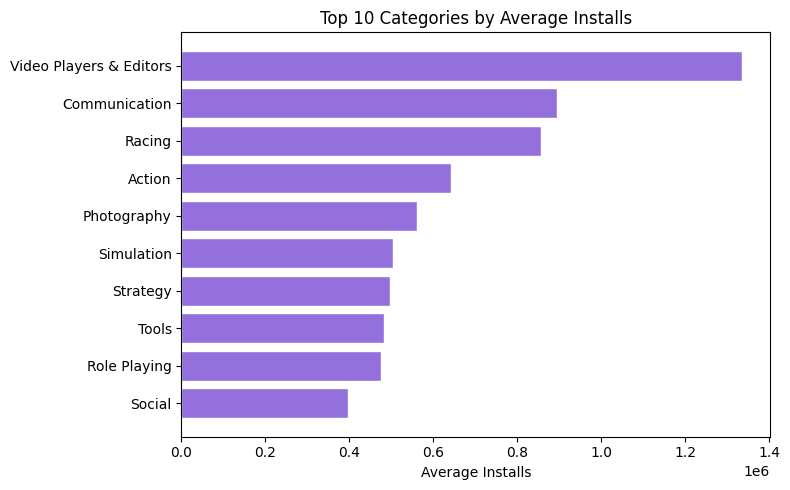

Category
Video Players & Editors    1.335817e+06
Communication              8.935923e+05
Racing                     8.568856e+05
Action                     6.414307e+05
Photography                5.610269e+05
Simulation                 5.044698e+05
Strategy                   4.957759e+05
Tools                      4.822192e+05
Role Playing               4.742591e+05
Social                     3.956017e+05
Name: Installs, dtype: float64


In [ ]:
# EDA 4: Top 10 Categories by Average Installs
if 'Category' in df.columns:
    top_cats = (
        df.groupby('Category')['Installs']
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    plt.figure(figsize=(8, 5))
    plt.barh(top_cats.index[::-1], top_cats.values[::-1], color='mediumpurple', edgecolor='white')
    plt.title('Top 10 Categories by Average Installs')
    plt.xlabel('Average Installs')
    plt.tight_layout()
    plt.show()

    print(top_cats)
else:
    print("'Category' column not found in dataset.")

### Cell 5 — Rating vs Installs Scatter:

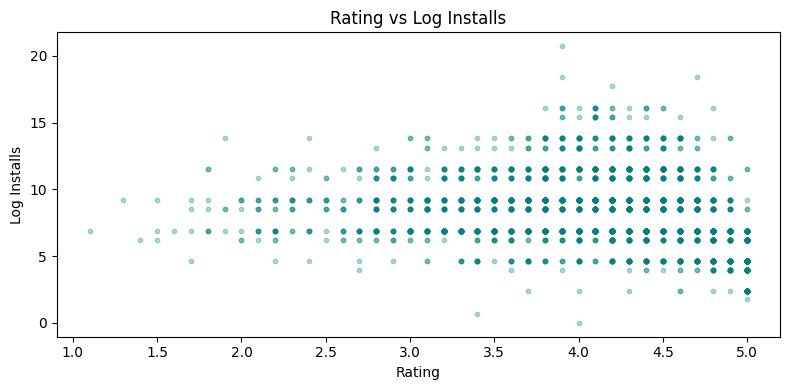

Correlation between Rating and Log Installs: 0.6393


In [ ]:
# EDA 5: Rating vs Log Installs
sample = df[df['Rating'] > 0].sample(min(3000, len(df)), random_state=42)

plt.figure(figsize=(8, 4))
plt.scatter(sample['Rating'], sample['Log_Installs'], alpha=0.3, color='teal', s=10)
plt.title('Rating vs Log Installs')
plt.xlabel('Rating')
plt.ylabel('Log Installs')
plt.tight_layout()
plt.show()

corr_val = df[['Rating', 'Log_Installs']].corr().iloc[0, 1]
print(f"Correlation between Rating and Log Installs: {corr_val:.4f}")

### Cell 6 — Correlation Heatmap:

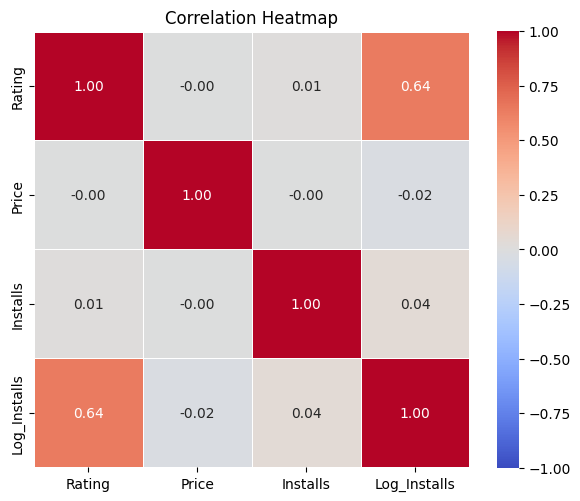

In [ ]:
# EDA 6: Correlation Heatmap
corr = df[['Rating', 'Price', 'Installs', 'Log_Installs']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## Step 4: K-Means Clustering (Market Segmentation)
Cluster apps into market segments based on Rating, Price, and Log Installs.

In [ ]:
cluster_data = df[['Rating', 'Price', 'Log_Installs']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

print('Cluster distribution:')
print(df['Cluster'].value_counts().sort_index())

Cluster distribution:
Cluster
0     599674
1        145
2    1024772
3     553246
Name: count, dtype: int64


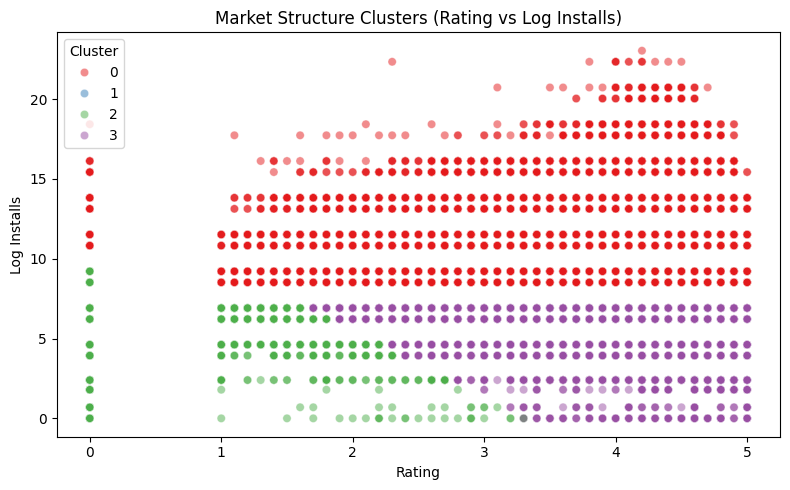

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Rating'], y=df['Log_Installs'], hue=df['Cluster'], palette='Set1', alpha=0.5)
plt.title('Market Structure Clusters (Rating vs Log Installs)')
plt.xlabel('Rating')
plt.ylabel('Log Installs')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Step 5: Demand Estimation — Implementation of Logistic Regression Model
We train a Linear Regression model **only on paid apps** (Price > 0 and Rating > 0).
The model learns: **how Rating and Price affect the number of Installs**.

In [ ]:
# Filter: paid apps with valid ratings only
paid_df = df[(df['Price'] > 0) & (df['Rating'] > 0)].copy()
print(f'Paid apps used for training: {len(paid_df)}')

# Features: Rating and Price
# Target: Log Installs (smoother to predict)
X = paid_df[['Rating', 'Price']]
y = paid_df['Log_Installs']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

print('Model trained successfully!')

Paid apps used for training: 24751
Model trained successfully!


In [ ]:
# Evaluate model
y_pred = model.predict(X_test)

print('=== Model Performance ===')
print(f'R2 Score : {r2_score(y_test, y_pred):.4f}')
print(f'MAE      : {mean_absolute_error(y_test, y_pred):.4f}')

print()
print('=== Regression Coefficients ===')
for feature, coef in zip(['Rating', 'Price'], model.coef_):
    print(f'  {feature}: {coef:.4f}')
print(f'  Intercept: {model.intercept_:.4f}')

=== Model Performance ===
R2 Score : 0.0059
MAE      : 1.6531

=== Regression Coefficients ===
  Rating: -0.2244
  Price: -0.0079
  Intercept: 7.8703


## Step 6: Revenue Prediction
**User inputs their app's Rating and Price → Model predicts expected Installs → Revenue = Installs × Price**

In [ ]:
def predict_revenue(rating, price):
    """
    Predicts expected installs and revenue for a paid app.

    Parameters:
        rating (float): App rating between 1.0 and 5.0
        price  (float): App price in USD (must be > 0 for paid apps)

    Returns:
        Prints expected installs and estimated revenue.
    """
    if price <= 0:
        print('ERROR: Price must be greater than 0 for a paid app.')
        return
    if not (1.0 <= rating <= 5.0):
        print('ERROR: Rating must be between 1.0 and 5.0.')
        return

    # Predict log installs using the trained model
    log_installs = model.predict([[rating, price]])[0]

    # Convert back from log scale to actual installs
    installs = np.expm1(log_installs)
    installs = max(0, round(installs))  # Ensure non-negative

    # Revenue = installs × price
    revenue = installs * price

    print('=====================================')
    print('       APP REVENUE PREDICTION        ')
    print('=====================================')
    print(f'  App Rating         : {rating}')
    print(f'  App Price          : ${price:.2f}')
    print('-------------------------------------')
    print(f'  Expected Installs  : {installs:,}')
    print(f'  Estimated Revenue  : ${revenue:,.2f}')
    print('=====================================')

In [ ]:
# -----------------------------------------------
# CHANGE THESE VALUES TO TEST YOUR OWN APP
# -----------------------------------------------
app_rating = 4.5   # Rating between 1.0 and 5.0
app_price  = 2.99  # Price in USD (must be > 0)

predict_revenue(app_rating, app_price)

       APP REVENUE PREDICTION        
  App Rating         : 4.5
  App Price          : $2.99
-------------------------------------
  Expected Installs  : 931
  Estimated Revenue  : $2,783.69


In [ ]:
# Try a few more examples
print('--- Example 1: High rated, low price ---')
predict_revenue(4.8, 0.99)

print()
print('--- Example 2: Average rated, medium price ---')
predict_revenue(3.5, 4.99)

print()
print('--- Example 3: High rated, premium price ---')
predict_revenue(4.7, 9.99)

--- Example 1: High rated, low price ---
       APP REVENUE PREDICTION        
  App Rating         : 4.8
  App Price          : $0.99
-------------------------------------
  Expected Installs  : 884
  Estimated Revenue  : $875.16

--- Example 2: Average rated, medium price ---
       APP REVENUE PREDICTION        
  App Rating         : 3.5
  App Price          : $4.99
-------------------------------------
  Expected Installs  : 1,147
  Estimated Revenue  : $5,723.53

--- Example 3: High rated, premium price ---
       APP REVENUE PREDICTION        
  App Rating         : 4.7
  App Price          : $9.99
-------------------------------------
  Expected Installs  : 842
  Estimated Revenue  : $8,411.58


## Step 7: Business Interpretation

- **Rating as a quality signal**: Higher-rated apps tend to get more installs. The model's Rating coefficient shows how strongly user perception drives demand.
- **Price elasticity**: Higher prices generally reduce installs (negative Price coefficient), demonstrating classic demand elasticity.
- **Market Segmentation (Clusters)**: The 4 clusters reveal distinct market segments — e.g., cheap/popular apps, niche premium apps, low-rated bargain apps, etc.
- **Revenue Formula**: `Revenue = Predicted Installs × Price`. There is an optimal price point that balances volume (installs) and margin (price).
- **Practical use**: A developer can use `predict_revenue()` to simulate pricing scenarios before launching their app.


In [ ]:
import joblib

# Save the trained model
joblib.dump(model, 'revenue_model.pkl')
print("Model saved as revenue_model.pkl")

Model saved as revenue_model.pkl
